In [1]:
import json
import os
import pandas as pd

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt

/home/anna/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Anna Wojciechowska, Oslo, October 2024  
**Oslo Hydrodynamisk Laboratory Wavemker validation of OWHL**  

| **test details**          |                |          |
|---------------------------------|----------------|----------|
| **date**                   | 17th October 2024  14-16         |          |
| **place**                                  | 8Oslo University Hydrodynamisk Laboratory          |          |



| **Wavemaker Settings**          |                |          |
|---------------------------------|----------------|----------|
| **Amplitude**                   | 2 [V]          |          |
| **Frequency**                   | 0.25 [Hz]      |          |

| **Ultrasound proble**          |                |          |
|---------------------------------|----------------|----------|
| **horizontal precision**                   |  0.09[mm]          |          |
| **sampling frequency**                   | 100 [Hz]      |          |

| **OWHL**          |                |          |
|---------------------------------|----------------|----------|
| **horizontal precision**                   | 80 [mbars]  0.8 [cm]        |          |
| **depth around**                                  | 0.5 [m]        |          |
| **sampling frequency**                   | 4 [Hz]      |          |

![test](owhl_wavemaker.jpg)

In [2]:
data_file = os.path.join(os.getcwd(), 'test_data', '2va025f30periods.csv')
column_names = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
ultra_df = pd.read_csv(data_file, header=None, names=column_names)
ultra_df.drop(columns=['sensor_1', 'sensor_2',  'sensor_3', 'sensor_5' ], inplace=True)
still_water_level = ultra_df['sensor_4'].mean()
ultra_df['sensor_4'] = (ultra_df['sensor_4'] - still_water_level) * 1000
ultra_df.index = pd.to_datetime(ultra_df.index)    
ultra_df.head(2)

,sensor_4
2024-10-17 13:45:29.144,0.34432
2024-10-17 13:45:29.152,0.34432


In [3]:
still_water_level

0.15335568000000002

In [4]:
data_file = os.path.join(os.getcwd(), 'test_data' , 'owhl_2024_10_17_15-16.csv')
owhl_df = pd.read_csv(data_file, skiprows=1)
owhl_df['frac_string'] = owhl_df['frac.seconds'].apply(lambda x: str(x))
owhl_df['dt_string'] = owhl_df['DateTime'].apply(lambda x: str(x))
owhl_df['time'] = pd.to_datetime( owhl_df['dt_string'] + '.' + owhl_df['frac_string'])
owhl_df.index = pd.to_datetime(owhl_df.time)
owhl_df.index = owhl_df.index - pd.Timedelta(hours=2) 
owhl_df.drop(columns=['POSIXt', 'DateTime',  'frac.seconds', 'TempC', 'frac_string', 'dt_string' ,'time'], inplace=True)
owhl_df.rename(columns={'Pressure.mbar': 'pressure_mbar'}, inplace=True)
owhl_df.head(2)

,pressure_mbar
time,
2024-10-17 13:00:00.000,1052.5
2024-10-17 13:00:00.250,1052.6


OWHL precision: 0.7999999999999545 [mbar] 
OWHL measued range: 9.0 [mbar] 


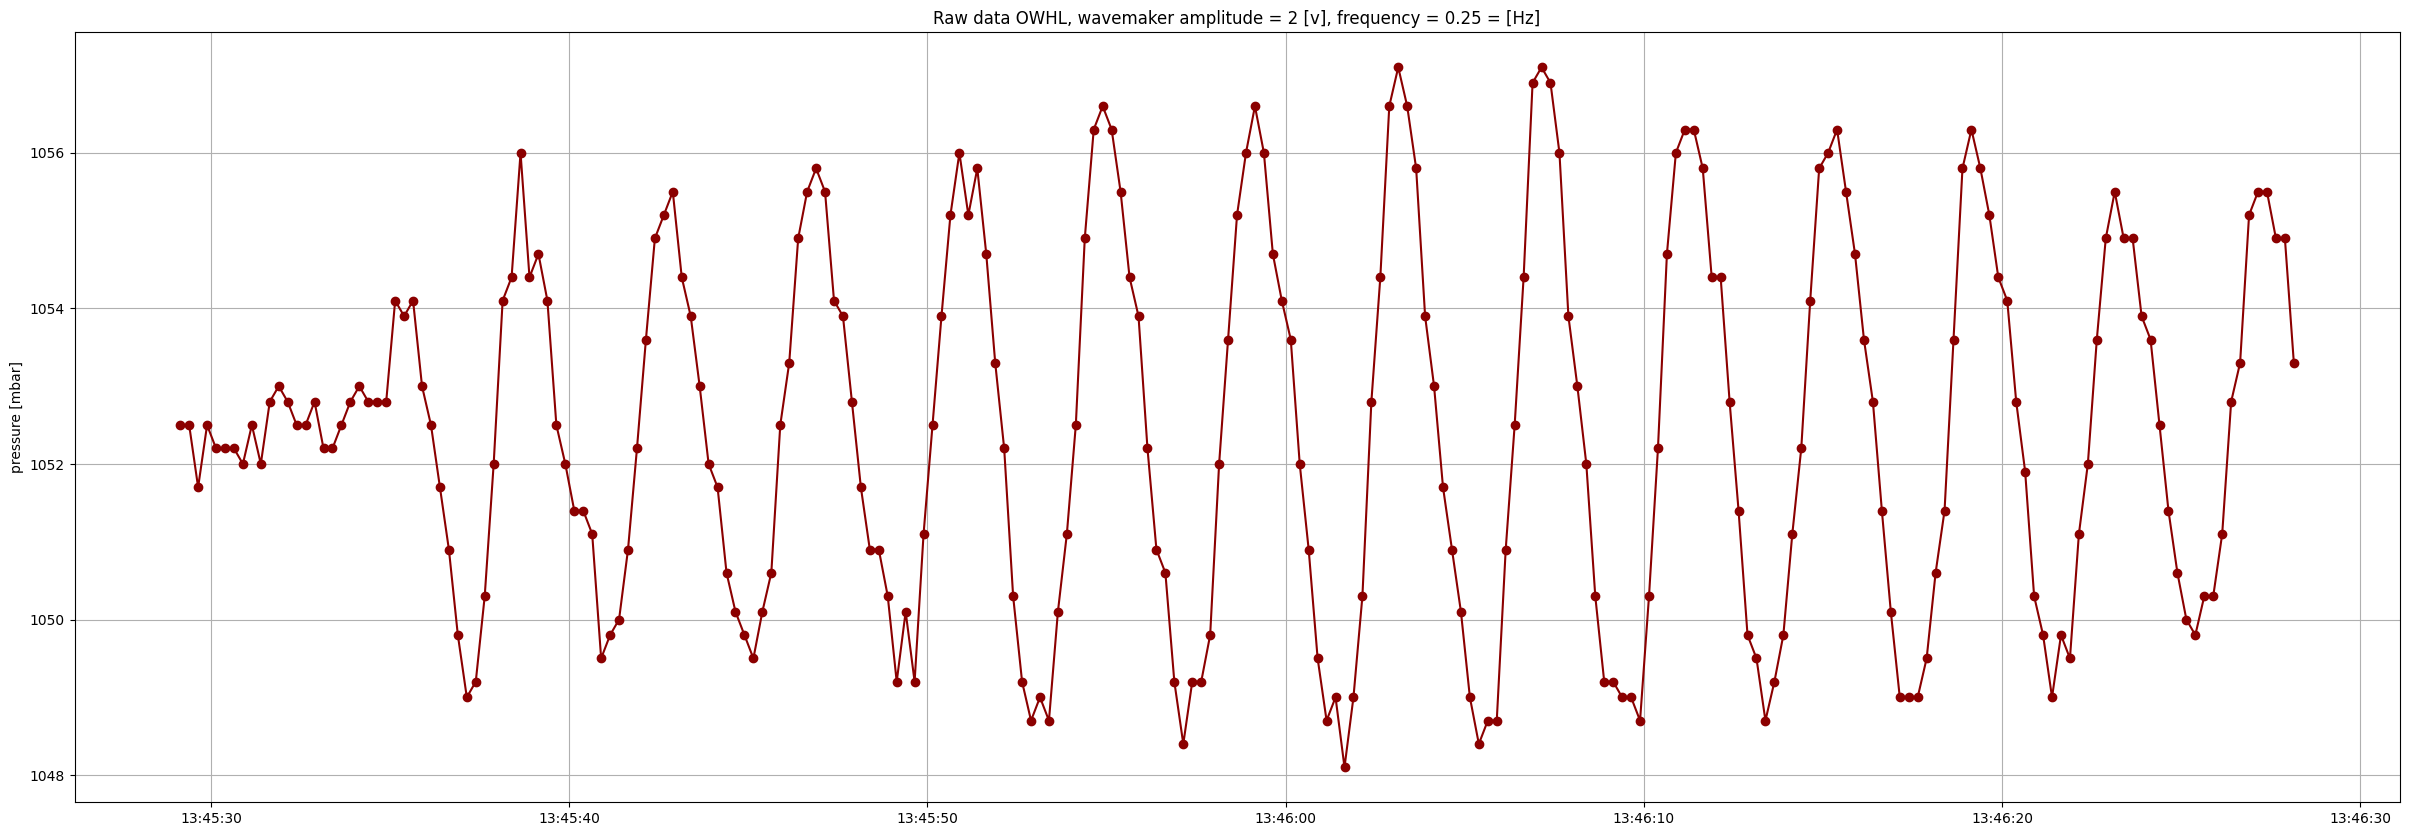

In [5]:
start_date_str = '2024-10-17 13:38:42'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S')
# we want the same duration as ultrasound data
ultra_time_span = ultra_df.index.max() - ultra_df.index.min()
end_date = start_date + timedelta(seconds=ultra_time_span.seconds)
owhl_wave = owhl_df[start_date:end_date].copy()
still_sample = owhl_wave[0:4]
precision = still_sample['pressure_mbar'].max() - still_sample['pressure_mbar'].min()
print(f"OWHL precision: {precision } [mbar] ")
measued_range = owhl_wave['pressure_mbar'].max() - owhl_wave['pressure_mbar'].min()
print(f"OWHL measued range: {measued_range } [mbar] ")

#there is time shift between ultrasound data and owhl, so i correct it
time_shift = ultra_df.index.min()  - start_date
shift_total_seconds = time_shift.total_seconds()
shift_minutes = int(shift_total_seconds // 60)
shift_seconds = shift_total_seconds % 60
owhl_wave.index = owhl_wave.index + pd.Timedelta(minutes=shift_minutes, seconds = shift_seconds) 

plt.figure(figsize=(30, 10))
plt.title('Raw data OWHL, wavemaker amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.ylabel('pressure [mbar]')

plt.plot(owhl_wave.index, owhl_wave.pressure_mbar, label='owhl', marker='o', linestyle='-', color='darkred')
plt.grid(True)

Ulrasound probe measured range: 100.15 [mm] 


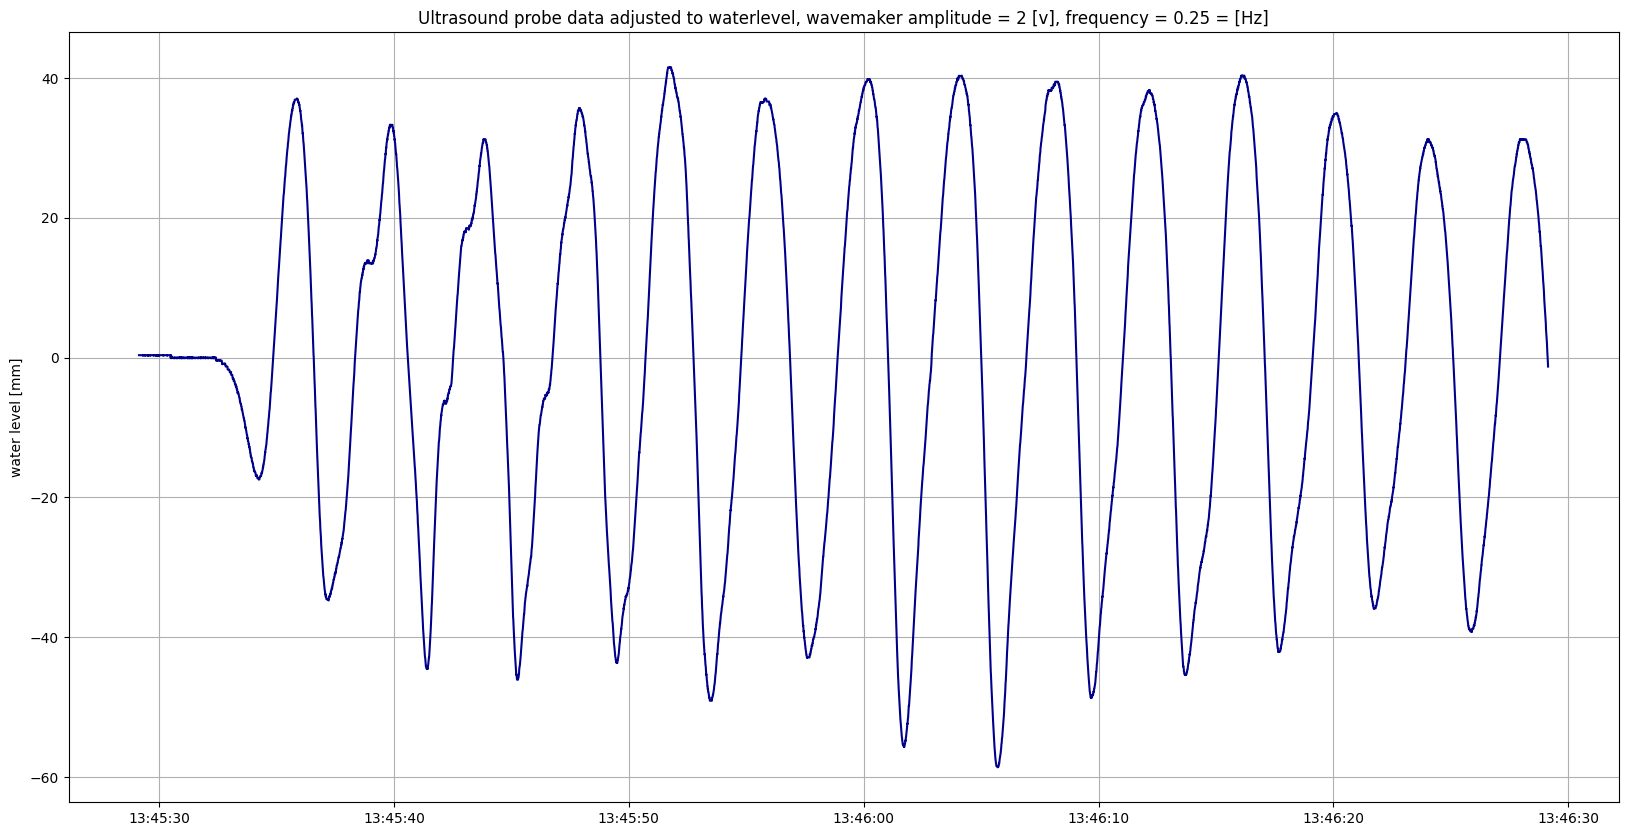

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(ultra_df.index, ultra_df.sensor_4, label='ultrasound', color='darkblue')
measured_range = ultra_df['sensor_4'].max() - ultra_df['sensor_4'].min()
print(f"Ulrasound probe measured range: {measured_range } [mm] ")
plt.title('Ultrasound probe data adjusted to waterlevel, wavemaker amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.ylabel('water level [mm]')
plt.grid(True)

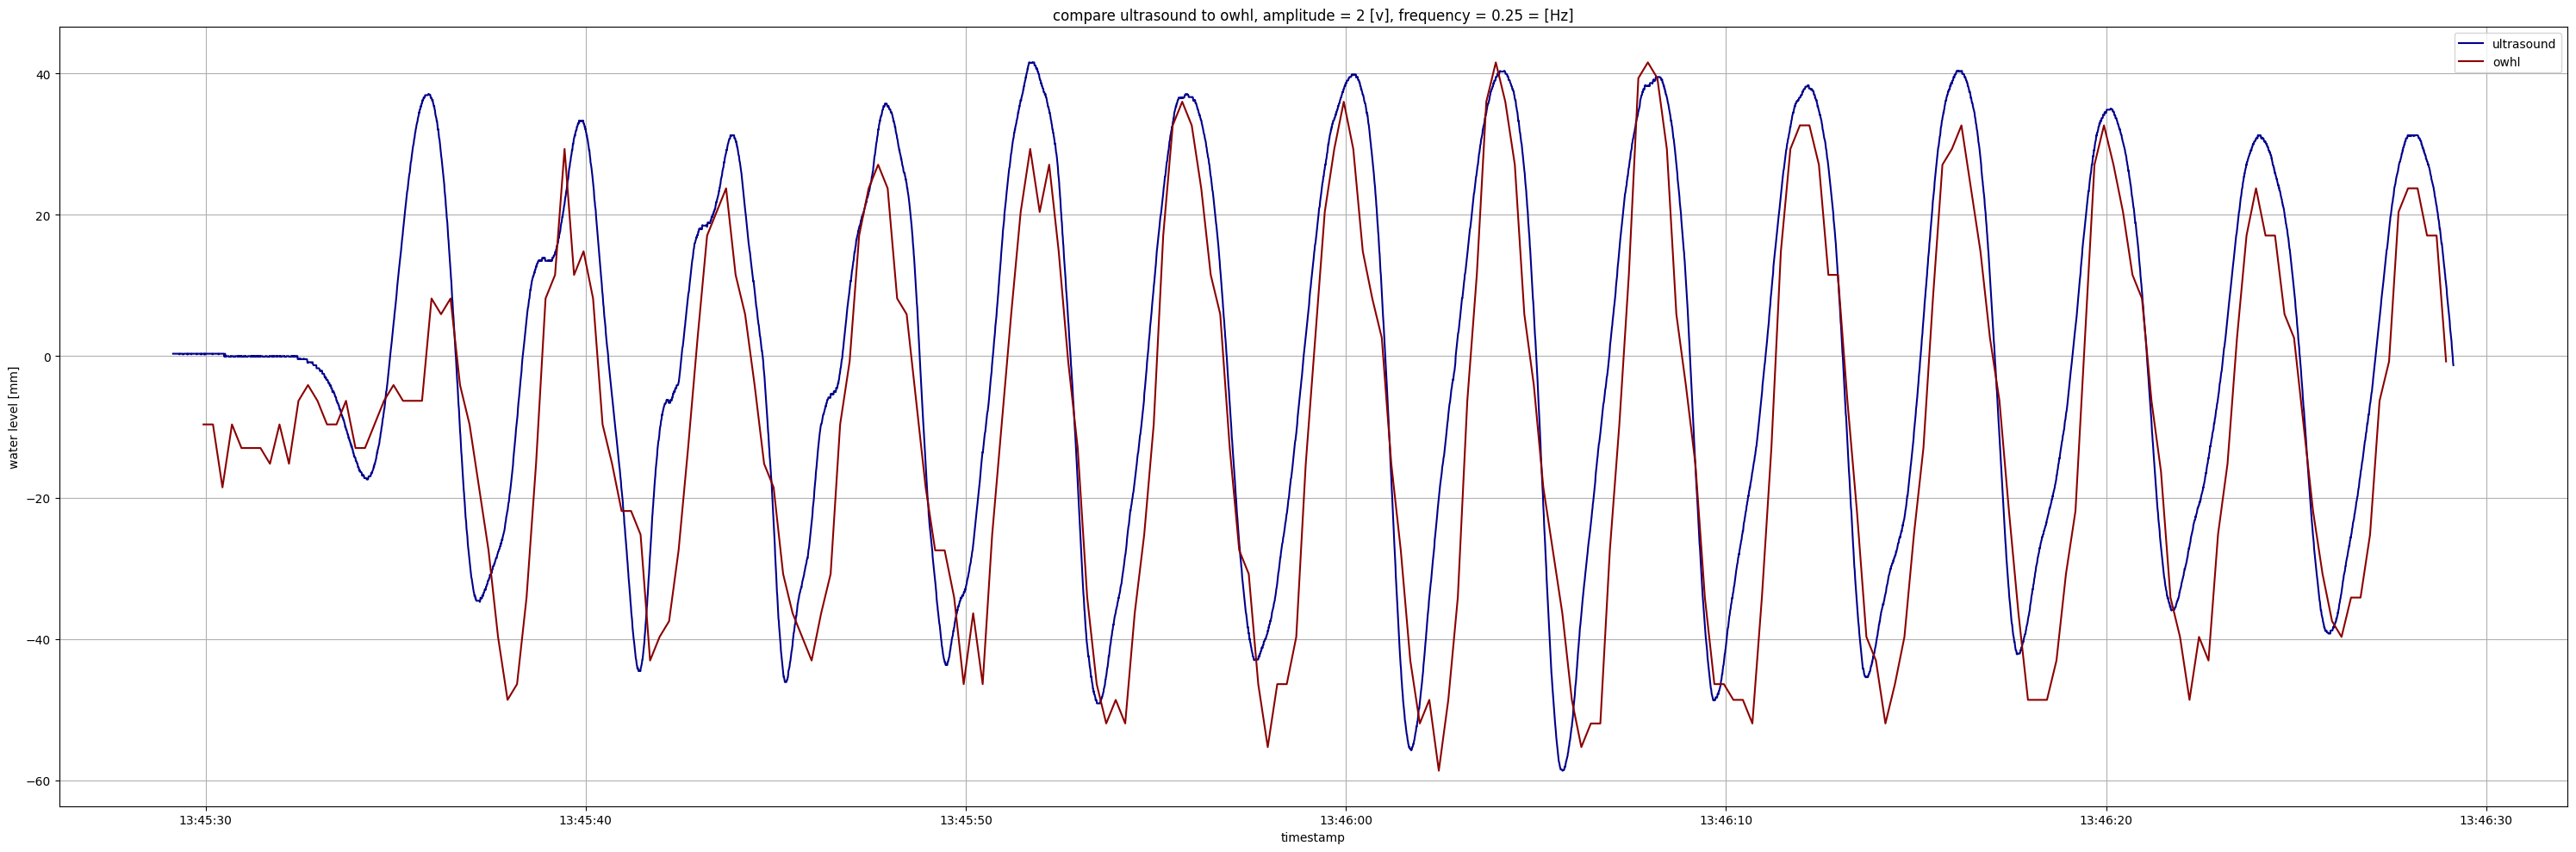

In [7]:
plt.figure(figsize=(30, 10))

owhl_wave.index = owhl_wave.index + pd.Timedelta( milliseconds = 800) 
min_ultra, max_ultra = ultra_df.sensor_4.min(), ultra_df.sensor_4.max()
min_owhl, max_owhl = owhl_wave.pressure_mbar.min(), owhl_wave.pressure_mbar.max()

owhl_wave['scaled_owhl'] = (owhl_wave.pressure_mbar - min_owhl) * ((max_ultra - min_ultra)/(max_owhl - min_owhl)) + min_ultra
plt.plot(ultra_df.index, ultra_df.sensor_4, label='ultrasound', color='darkblue')
plt.plot(owhl_wave.index, owhl_wave.scaled_owhl, label='owhl', color='darkred')

plt.title('compare ultrasound to owhl, amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.xlabel('timestamp')
plt.ylabel('water level [mm]')
plt.grid(True)
plt.legend()
plt.tight_layout()  
plt.savefig('owhl_vs_ultrasound', dpi=300) 
plt.show()

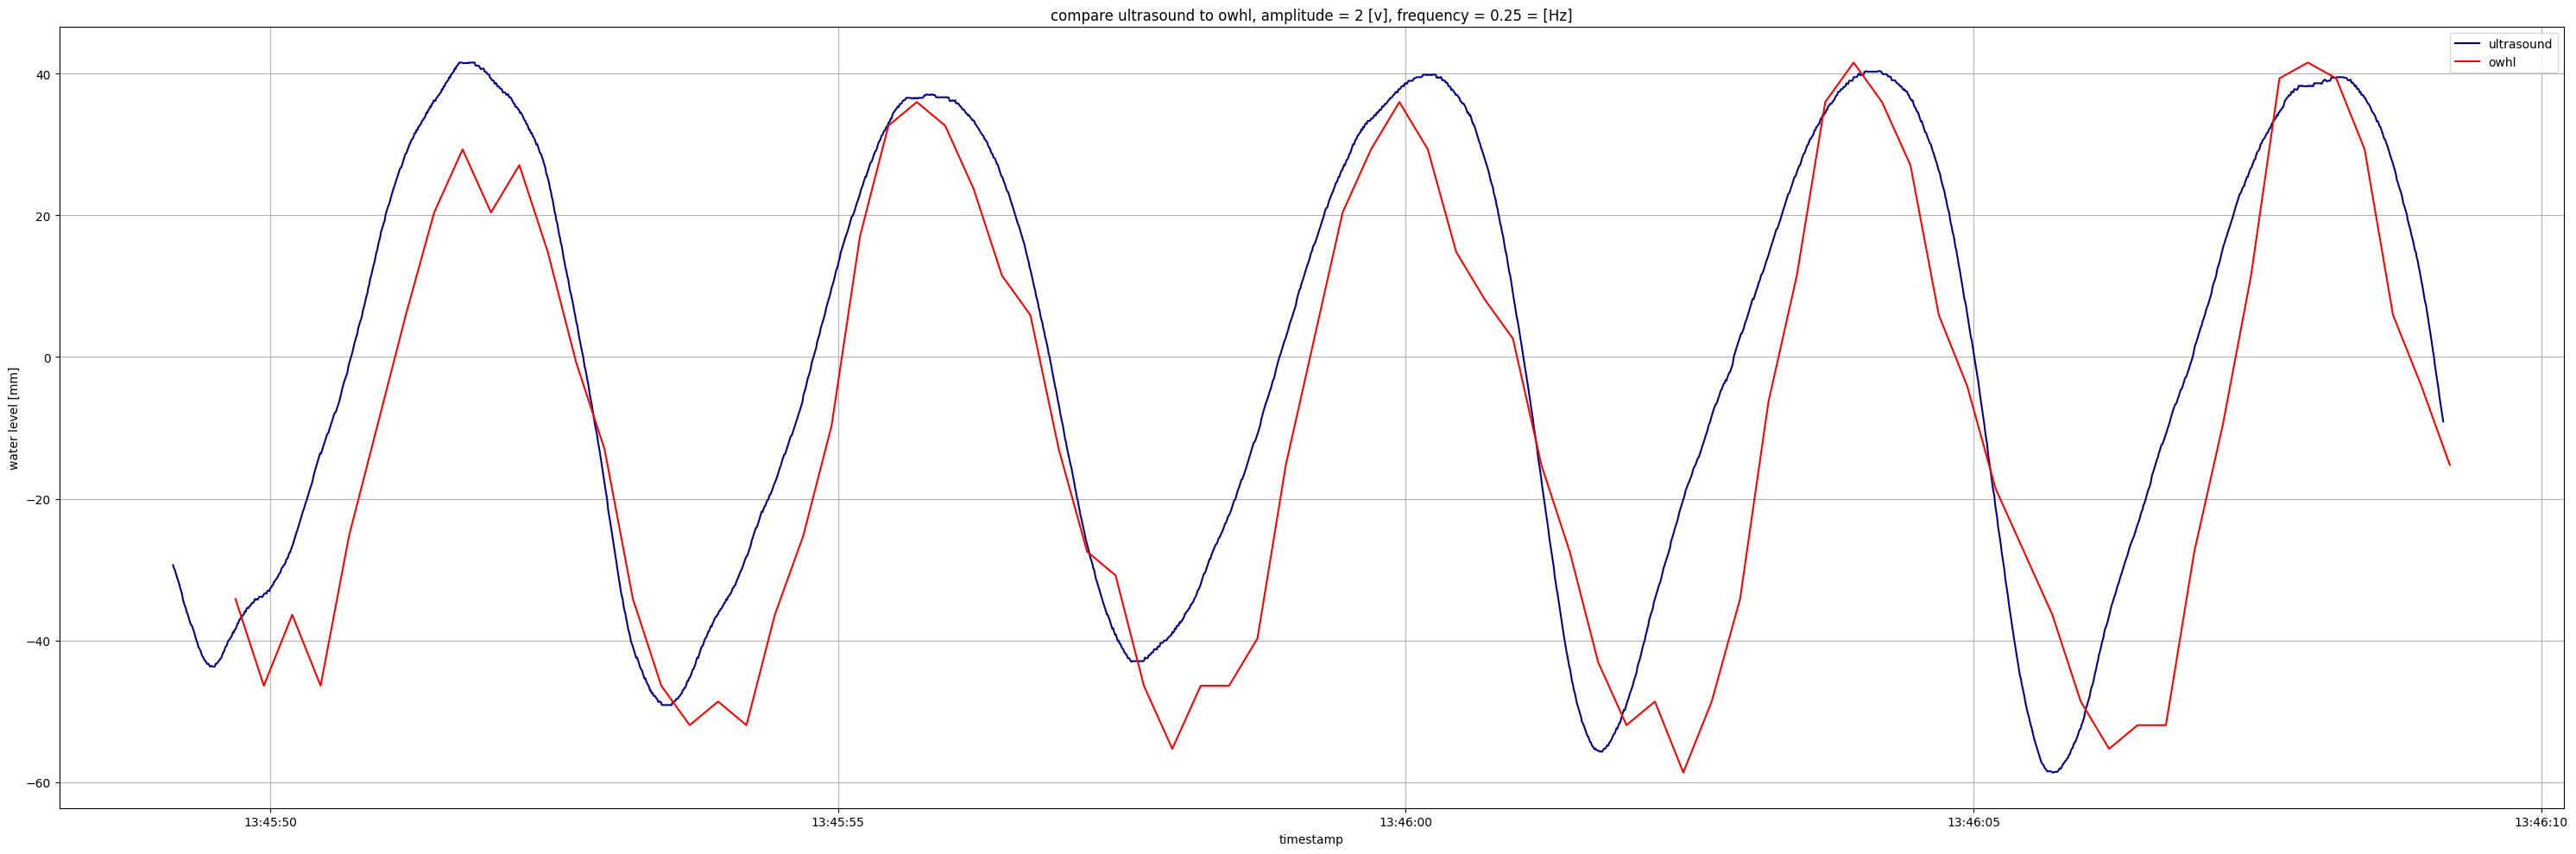

In [8]:
o_idx = len(owhl_wave.index) // 3
u_idx = len(ultra_df.index) // 3

plt.figure(figsize=(30, 10))

#owhl_wave.index = owhl_wave.index - pd.Timedelta( milliseconds = 400) 

plt.plot(ultra_df.index[u_idx:2*u_idx], ultra_df.sensor_4.iloc[u_idx:2*u_idx], label='ultrasound', color='darkblue')
plt.plot(owhl_wave.index[o_idx:2*o_idx], owhl_wave.scaled_owhl[o_idx:2*o_idx], label='owhl', color='red')

plt.title('compare ultrasound to owhl, amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.xlabel('timestamp')
plt.ylabel('water level [mm]')
plt.grid(True)
plt.legend()
plt.tight_layout()  
plt.savefig('owhl_vs_ultrasound', dpi=300) 
plt.show()

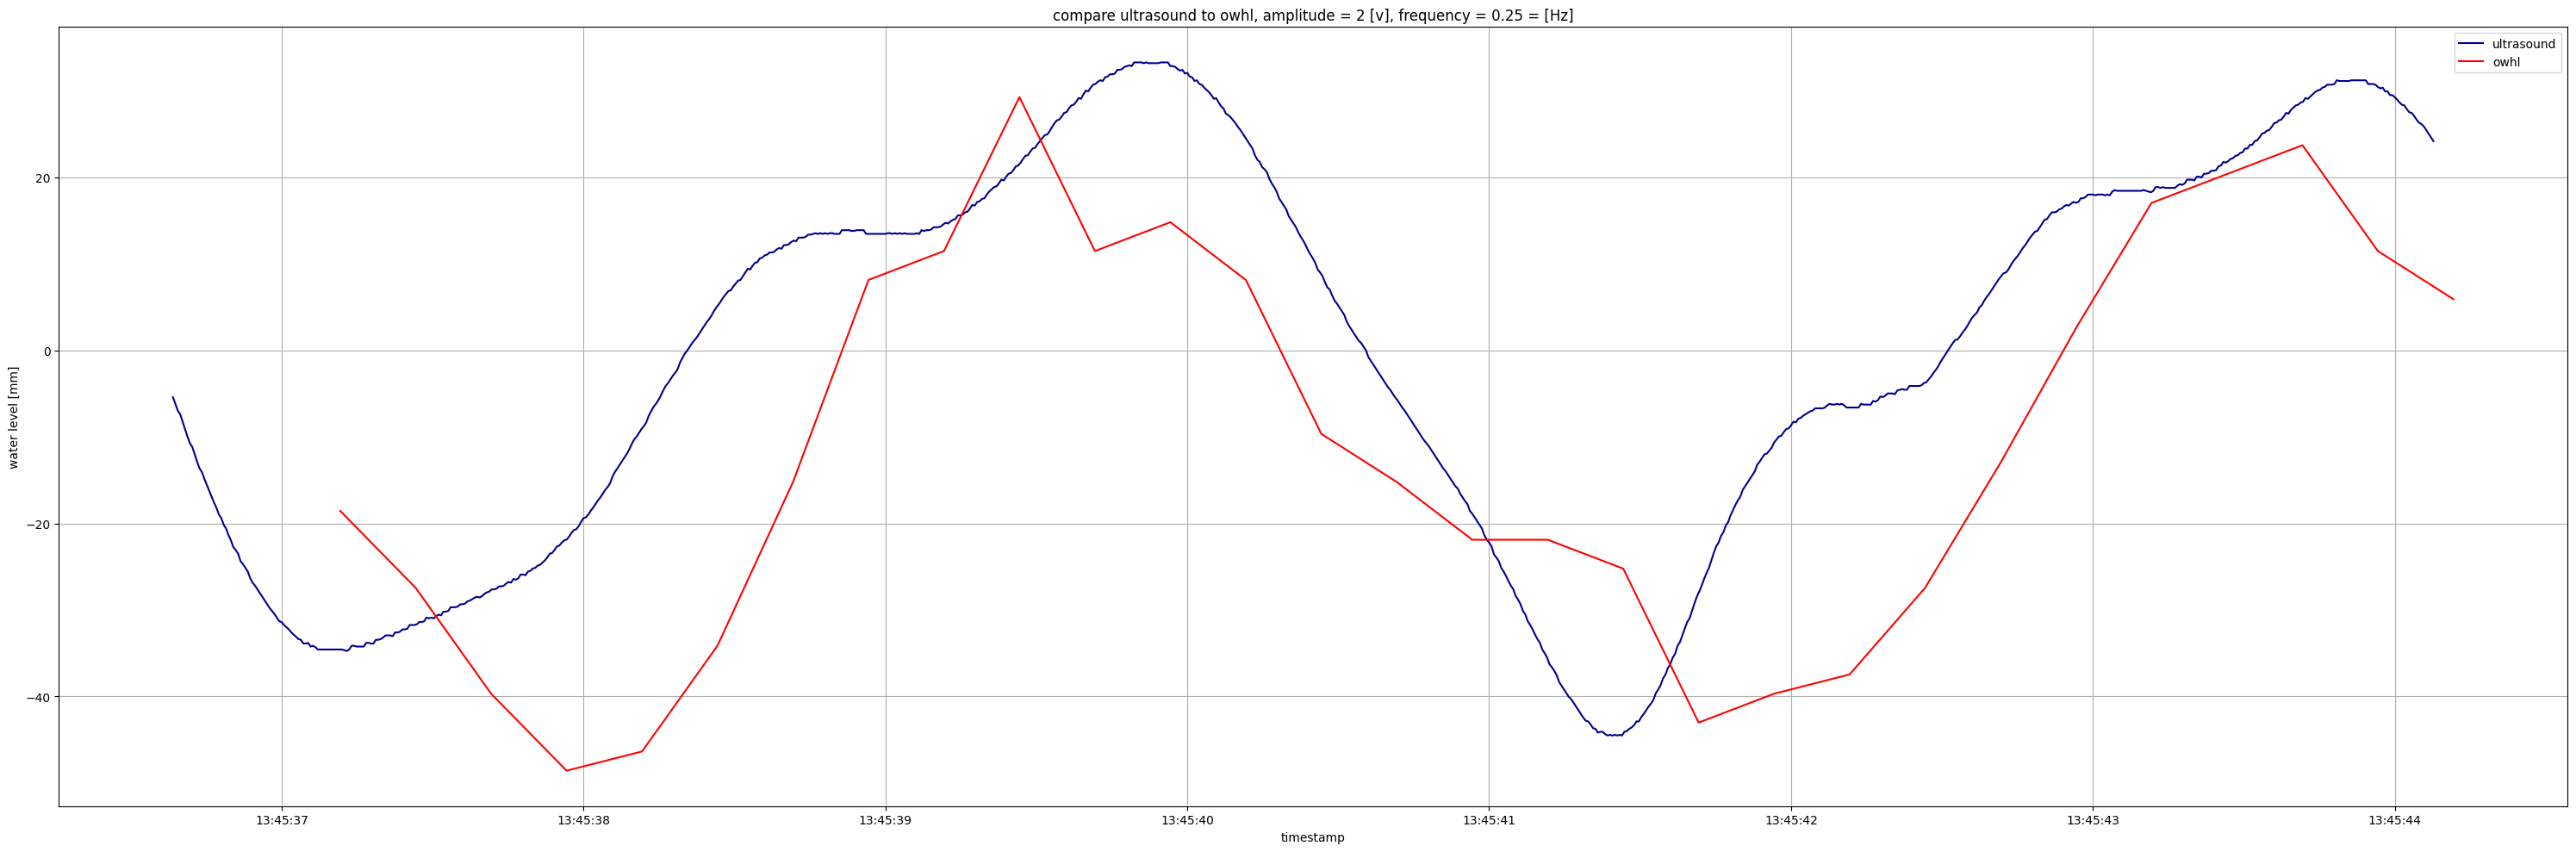

In [9]:
#owhl_wave.index = owhl_wave.index + pd.Timedelta( milliseconds = 400) 
o_idx = len(owhl_wave.index) // 8
u_idx = len(ultra_df.index) // 8

plt.figure(figsize=(30, 10))


plt.plot(ultra_df.index[u_idx:2*u_idx], ultra_df.sensor_4.iloc[u_idx:2*u_idx], label='ultrasound', color='darkblue')
plt.plot(owhl_wave.index[o_idx:2*o_idx], owhl_wave.scaled_owhl[o_idx:2*o_idx], label='owhl', color='red')

plt.title('compare ultrasound to owhl, amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.xlabel('timestamp')
plt.ylabel('water level [mm]')
plt.grid(True)
plt.legend()
plt.tight_layout()  
plt.savefig('owhl_vs_ultrasound', dpi=300) 
plt.show()

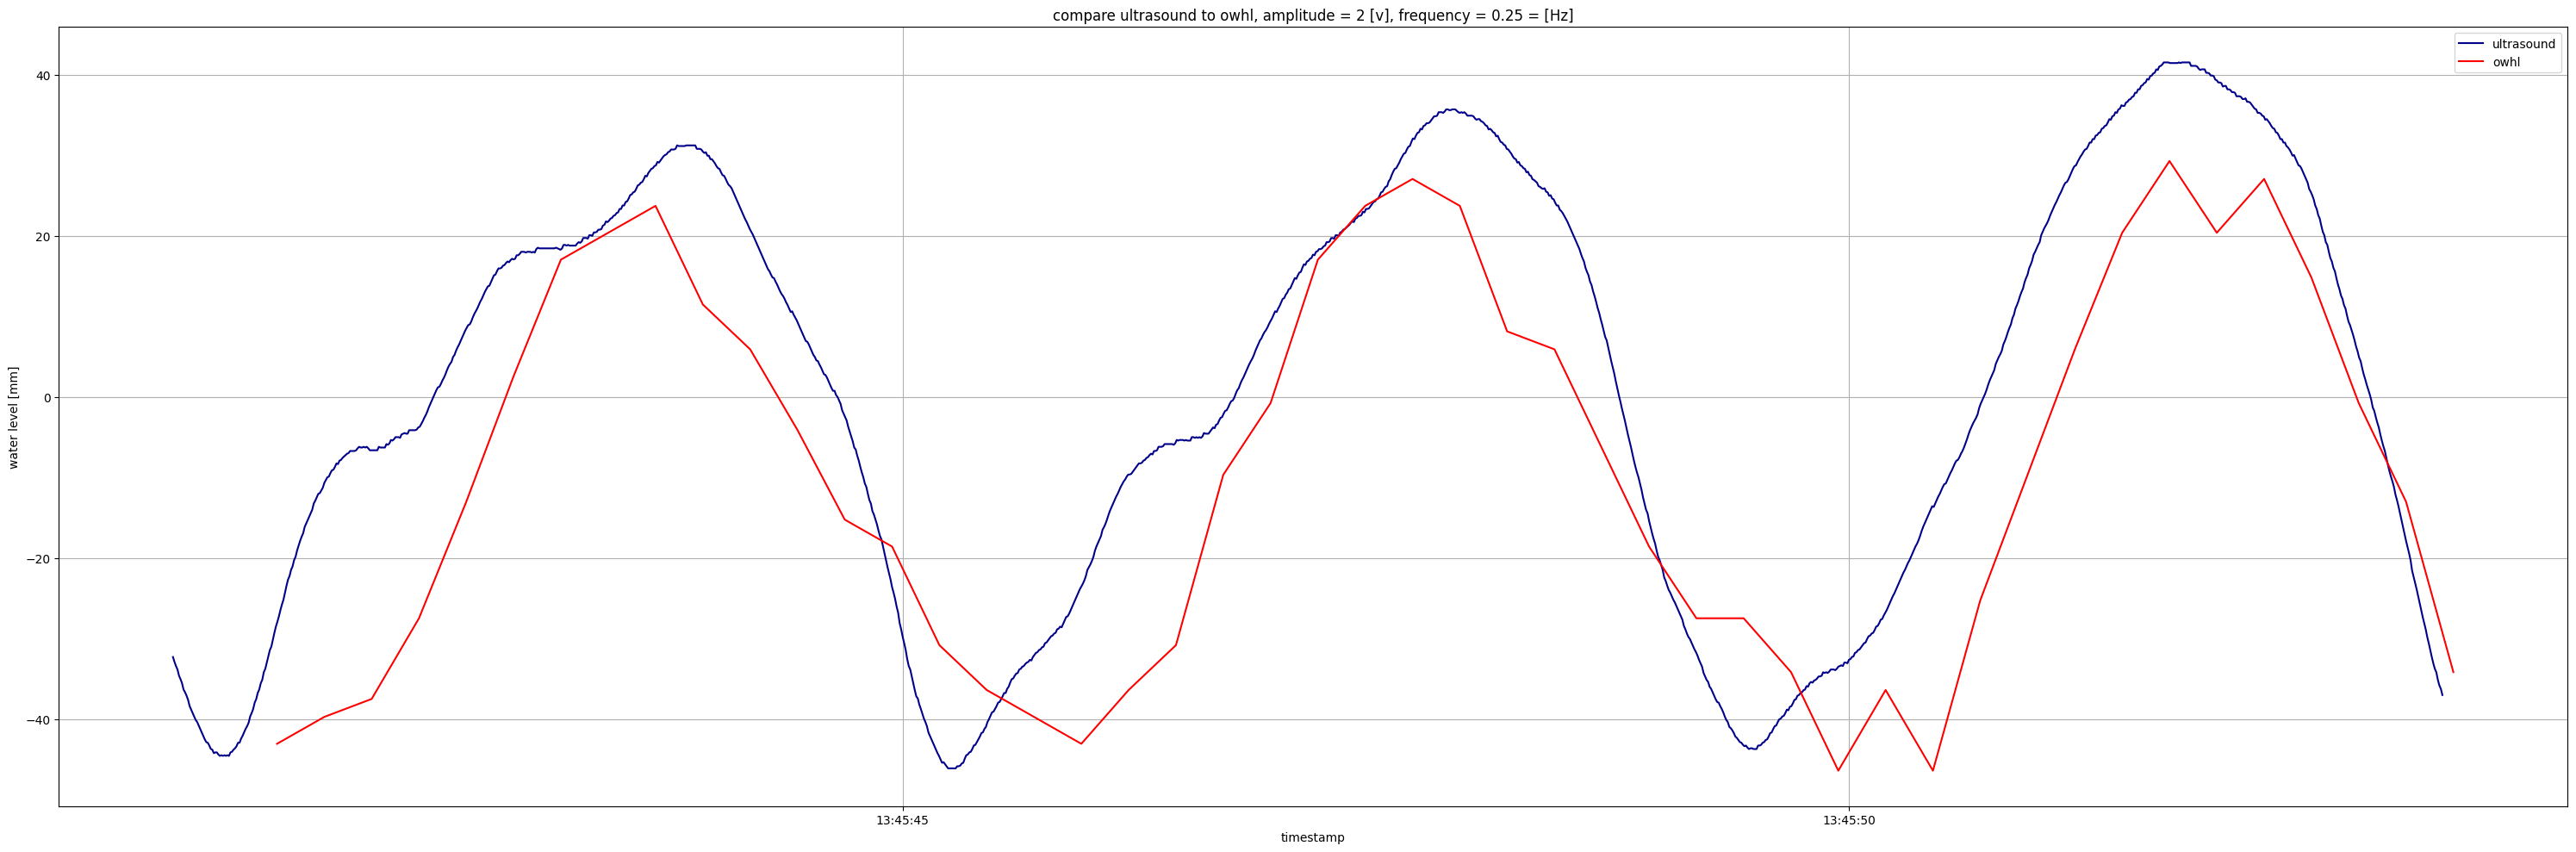

In [10]:
o_idx = len(owhl_wave.index) // 5
u_idx = len(ultra_df.index) // 5

plt.figure(figsize=(30, 10))

owhl_wave.index = owhl_wave.index + pd.Timedelta( milliseconds = 0) 

plt.plot(ultra_df.index[u_idx:2*u_idx], ultra_df.sensor_4.iloc[u_idx:2*u_idx], label='ultrasound', color='darkblue')
plt.plot(owhl_wave.index[o_idx:2*o_idx], owhl_wave.scaled_owhl[o_idx:2*o_idx], label='owhl', color='red')

plt.title('compare ultrasound to owhl, amplitude = 2 [v], frequency = 0.25 = [Hz]')
plt.xlabel('timestamp')
plt.ylabel('water level [mm]')
plt.grid(True)
plt.legend()
plt.tight_layout()  
plt.savefig('owhl_vs_ultrasound', dpi=300) 
plt.show()